# Check to see if we're running in Colab (versus local server)

In [2]:
try:
    from google.colab import drive

    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    print("We're running Colab")

# Mount the Google Drive (if we're in Colab), switch current directory to a directory on the Google Drive
- we will (optionally) create the specified directory on the Google Drive if it doesn't exist

- navigate to our Harvard Capstone shared folder -> right-click -> organize -> add shortcut -> all locations -> add "My Drive"

In [3]:
if IN_COLAB:
    # Mount the Google Drive at mount
    mount = "/content/gdrive"
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Switch to the directory on the Google Drive that you want to use
    import os

    drive_root = mount + "/My Drive/Harvard Capstone/Modeling/UNet"

    # Create drive_root if it doesn't exist
    # create_drive_root = True
    # if create_drive_root:
    #  print("\nColab: making sure ", drive_root, " exists.")
    #  os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root

# Work with files on the Google Drive
- existing files
- upload files to Google Drive (as per normal)
- load files from external source

In [4]:
# Verify we're in the correct working directory
%pwd

'/home/bacon/code/personal/icedyno/unet_model'

## Verify that imports (of modules on the Google Drive) work

In [5]:
import glob, json, os
import datetime as dt
import datetime
from IPython.display import HTML

import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy import ndimage
from scipy.ndimage import sobel, binary_erosion, label
import skimage

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Dropout,
    Conv2DTranspose,
    concatenate,
    Input,
    Lambda,
    Activation,
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    concatenate,
    Conv2DTranspose,
    Input,
    Lambda,
    Activation,
    Add,
    Reshape,
)
from tensorflow.keras.models import Model

# Set configuration constants

In [6]:
data_root = "ims_netcdf_1km_cropped_2_000km_window_74lat_-170lon/"
if not IN_COLAB:
    data_root = os.path.join("..", "data", data_root)
    tf.config.set_visible_devices([], "GPU")
WINDOW_SIZE = 2000  # km

2024-03-26 19:17:47.398220: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-03-26 19:17:47.398291: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: sven
2024-03-26 19:17:47.398301: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: sven
2024-03-26 19:17:47.398673: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.104.5
2024-03-26 19:17:47.398707: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.104.5
2024-03-26 19:17:47.398714: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 535.104.5


In [69]:
batch_size = 1
test_batch_size = 1
dim = (WINDOW_SIZE, WINDOW_SIZE, 5)

## Data Processing: XArray and Numpy


In [8]:
# Define a function to load a single .nc file for a given year and day
def load_nc_file(year, day) -> xr.Dataset:
    """Loads the cropped, grid-corrected netcdf files on the Beaufort Sea with 74,0lat_-170,0lon"""
    # Generate the file path based on the year and day
    file_path = os.path.join(
        data_root,
        str(year),
        f"ims{year}{day:03d}_1km_v1.3_grid{WINDOW_SIZE}_74,0lat_-170,0lon.nc",
    )

    # Load the .nc file using xarray
    with xr.open_dataset(file_path) as dataset:
        return dataset

In [9]:
def crop_to_beaufort_sea(ds: xr.Dataset, window_size: int) -> xr.Dataset:
    """
    Center window on beaufort sea coordinates in **current** netcdf coordinate system (not quite polar stereographic) and
    crop to WINDOW_SIZE x WINDOW_SIZE (not 2*window size x 2*window size as was previously)
    """
    # Beaufort Sea x, y in **current** IMS netcdf coordinate system
    x = -1652603.364653003  # meters
    y = -291398.56159791426  # meters

    # These x, y in convert back to the below with current geolocation.py functions.
    ## longitude: -80.0, latitude: 74.0
    # Actual Beaufort Sea coordinates are closer to longitude: -140, latitude: 74.

    beaufort_ds = ds.sel(
        x=slice(x - 1000 * window_size // 2, x + 1000 * window_size // 2),
        y=slice(y - 1000 * window_size // 2, y + 1000 * window_size // 2),
    )
    return beaufort_ds

In [10]:
def load_sie_data(year, day) -> np.array:
    """Returns a 2D numpy array copy of the IMS surface values"""
    return load_nc_file(year, day).IMS_Surface_Values[0].values.copy()

In [11]:
def load_target_sie_data(year, day) -> np.array:
    """Returns a 2D numpy array copy of the IMS surface values"""
    ds = load_nc_file(year, day)
    sie = ds.IMS_Surface_Values[0].values.copy()
    binary_sie = sie.copy()
    binary_sie[sie != 3] = 0

    # Sea and Lake Ice is treated as 1
    binary_sie[sie == 3] = 1
    return binary_sie

In [12]:
def binarize_data(sie: np.array) -> np.array:
    """
    New SIE:
    0: Open water/out of bounds
    1: Sea ice or lake ice (lake mask not applied)
    2: Land
    """
    binary_sie = sie.copy()
    binary_sie[sie != 3] = 0

    # Sea and Lake Ice is treated as 1
    binary_sie[sie == 3] = 1

    # Land and Snow-Covered Land is sent to 2.
    binary_sie[sie == 2] = 2
    binary_sie[sie == 4] = 2
    return binary_sie

In [13]:
def load_n_day_chunk(year: int, day: int, n=4) -> np.array:
    """
    Return np.array with shape (height, width, channels).

    Does NOT wrap years or account for missing days.
    Starts n_day chunk at specified day, year.

    Returns:
        np.array: shape (sie_y_shape, sie_x_shape, n_day)
    """
    sie_chunk = []
    for day in range(day, day + n):
        sie = binarize_data(load_sie_data(year, day))
        sie_chunk.append(sie)

    assert len(sie_chunk) == n
    # Use np.stack to stack the individual 2D arrays along a new third axis, resulting in (height, width, channels)
    return np.stack(sie_chunk, axis=-1)

## Example usage

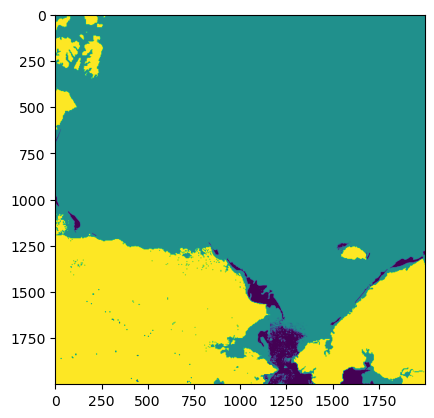

In [13]:
# Example usage:
example = True
if example:
    year = 2023
    day = 150
    data = load_nc_file(year, day)
    multiclass_sie = load_sie_data(year, day)
    sie = binarize_data(multiclass_sie)
    plt.imshow(sie)

# Data Processing: Loading data for Tensorflow

# Data generator for all data available
To be used as either train or test data generator, depending on slice of filenames passed in.

In [14]:
class AllDataGenerator(tf.keras.utils.Sequence):
    """
    Generator for Keras training to allow multiprocessing and training on batches with only the
    batch itself being loaded into memory.

    """

    def __init__(
        self,
        filenames: list[str],
        batch_size: int = 2,
        dim: tuple = (8000, 8000, 5),
        shuffle: bool = True,
    ):
        self.filenames = sorted(filenames)
        self.years = self.years_from_filenames()
        self.days = self.days_from_filenames()
        self.batch_size = batch_size
        self.dim = dim  # (height, width, channel)
        self.shuffle = True
        self.data_IDs = self._get_data_ids()
        self.on_epoch_end()

    def years_from_filenames(self):
        years = [
            int(file.split("/")[-1].split("ims")[1][:4]) for file in self.filenames
        ]
        return years

    def days_from_filenames(self):
        days = [int(file.split("/")[-1].split("_")[0][-3:]) for file in self.filenames]
        return days

    def _get_data_ids(self):
        return list(zip(self.years, self.days))

    def get_years_days_of_batch(self, index: int):
        """Given a batch index, return a list of the year and days for that batch"""
        years = self.years[index * self.batch_size : (index + 1) * self.batch_size]
        days = self.days[index * self.batch_size : (index + 1) * self.batch_size]
        return list(zip(years, days))

    def __len__(self):
        """Number of batches per epoch"""
        return len(self.data_IDs) // self.batch_size

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Collect data IDs for this batch number
        batch_data_ids = self.data_IDs[
            index * self.batch_size : (index + 1) * self.batch_size
        ]

        # Generate data
        X, y = self._data_generation(batch_data_ids)

        return X.astype("float16"), y.astype("int32")

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.data_IDs)

    def load_n_day_chunk(self, i, n):
        """Starts at year, day and returns the next n days of processed SIE."""
        days = self.days[i : i + n]
        years = self.years[i : i + n]

        sie_chunk = []
        for year, day in zip(years, days):
            sie = binarize_data(load_sie_data(year, day))
            sie_chunk.append(sie)

        assert len(sie_chunk) == n
        # Use np.stack to stack the individual 2D arrays along a new third axis, resulting in (height, width, channels)
        return np.stack(sie_chunk, axis=-1)

    def _data_generation(self, batch_data_ids):
        """Generates data containing batch_size samples"""
        X = np.empty((self.batch_size, *self.dim), dtype="float16")
        y = np.empty((self.batch_size, self.dim[0], self.dim[1], 1), dtype="int32")

        for i, (year, day) in enumerate(batch_data_ids):
            # Load a 5-day chunk as the input
            X[i,] = self.load_n_day_chunk(i, self.dim[2])
            # Load the next day as the target
            y[i,] = np.expand_dims(
                load_target_sie_data(
                    self.years[i + self.dim[2]], self.days[i + self.dim[2]]
                ),
                axis=-1,
            )

        return X, y

# Test/Train split

In [15]:
test_frac = 0.8
validation_frac = 0.1

train_frac = 1 - validation_frac - test_frac
all_netcdf_files = glob.glob(data_root + "/**/*.nc", recursive=True)

train_idx = int(len(all_netcdf_files) * train_frac)
test_idx = train_idx + int(len(all_netcdf_files) * test_frac)

train_files = all_netcdf_files[:train_idx]
test_files = all_netcdf_files[train_idx:test_idx]
validation_files = all_netcdf_files[test_idx:]

print("Number of Train files is: ", len(train_files))
print("Number of Test files is: ", len(test_files))
print("Number of Validation files is: ", len(validation_files))

Number of Train files is:  334
Number of Test files is:  2679
Number of Validation files is:  336


### Model prototype
Very simple UNet model that takes the entire region of interest in and outputs an image of the same size.

In [16]:
def simple_unet_with_softmax(input_shape=(4000 * 2, 4000 * 2, 5)):
    inputs = Input(input_shape)
    # Downsample
    c1 = Conv2D(16, (3, 3), activation="relu", padding="same")(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation="relu", padding="same")(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    # Bottleneck
    b = Conv2D(64, (3, 3), activation="relu", padding="same")(p2)
    # Upsample
    u1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(b)
    u1 = concatenate([u1, c2])
    u2 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(u1)
    u2 = concatenate([u2, c1])
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(u2)  # 0, 1, 2
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


def simple_unet_with_skip(input_shape: tuple[int, int, int]):
    """
    Unet to predict the change in sea ice concentration by adding last day's forecast
    to model output, then sigmoid activation for pixel-wise classification.
    """
    inputs = Input(input_shape)
    # Slice the last channel of the input
    last_channel = Lambda(lambda x: x[:, :, :, -1:])(
        inputs
    )  # Assuming the last channel is what we want to add to the output

    # Downsample
    c1 = Conv2D(16, (3, 3), activation="relu", padding="same")(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation="relu", padding="same")(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = Conv2D(64, (3, 3), activation="relu", padding="same")(p2)

    # Upsample
    u1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(b)
    u1 = concatenate([u1, c2])
    u2 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(u1)
    u2 = concatenate([u2, c1])

    # Concatenate the last channel of the input with the last upsampled features before the final convolution
    pre_output = concatenate([u2, last_channel], axis=-1)

    # Final convolution without activation
    outputs = Conv2D(1, (1, 1), padding="same", activation="softmax")(pre_output)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Model Training

In [17]:
train_generator = AllDataGenerator(train_files, batch_size=batch_size, dim=dim)
test_generator = AllDataGenerator(test_files, batch_size=test_batch_size, dim=dim)

In [18]:
# Setup model checkpointing
train = False
if train:
    datetime_string = datetime.datetime.now().strftime("%I:%M%p_%B_%d_%Y")

    # Model checkpoint foldernames now generated by datetime (won't overwrite previous runs)
    checkpoint_dir = (
        f"./model_checkpoints/jbacon/unet_{datetime_string}_{WINDOW_SIZE}km/"
    )
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:04d}.ckpt")

    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=False,
        monitor="loss",
        mode="min",
        save_best_only=True,
        verbose=1,
    )

    early_stopping_callback = EarlyStopping(
        monitor="loss", patience=10, verbose=1, mode="min"
    )

    model = simple_unet_with_softmax(input_shape=dim)  # skip(input_shape=dim)
    model.compile(
        optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
    )  #'binary_crossentropy', metrics=['accuracy']) 'sparse_categorical_crossentropy'
else:
    model = tf.keras.models.load_model(
        "./model_checkpoints/jbacon/unet_12:35PM_March_23_2024_2000km/cp-0003.ckpt"
    )

2024-03-26 19:17:49.982882: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
if train:
    # Log model parameters
    with open(os.path.join(checkpoint_dir, "model_params.json"), "w") as f:
        f.write(model.to_json())

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2000, 2000,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 2000, 2000, 1 448         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 1000, 1000, 1 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1000, 1000, 3 4640        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [21]:
if train:
    # Train the model
    history = model.fit(
        train_generator,
        epochs=20,
        # Only for training on CPU
        use_multiprocessing=True,
        workers=4,
        callbacks=[checkpoint_callback, early_stopping_callback],
    )

    # Save the final model
    model.save(os.path.join(checkpoint_path, "unet_with_2d_output_model.h5"))

In [22]:
if train:
    # Plot training history
    plt.plot(history.history["loss"], label="Loss")
    plt.plot(history.history["accuracy"], label="Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Metric")
    plt.legend()
    plt.show()

# Model Predictions

2024-03-26 19:17:53.199807: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


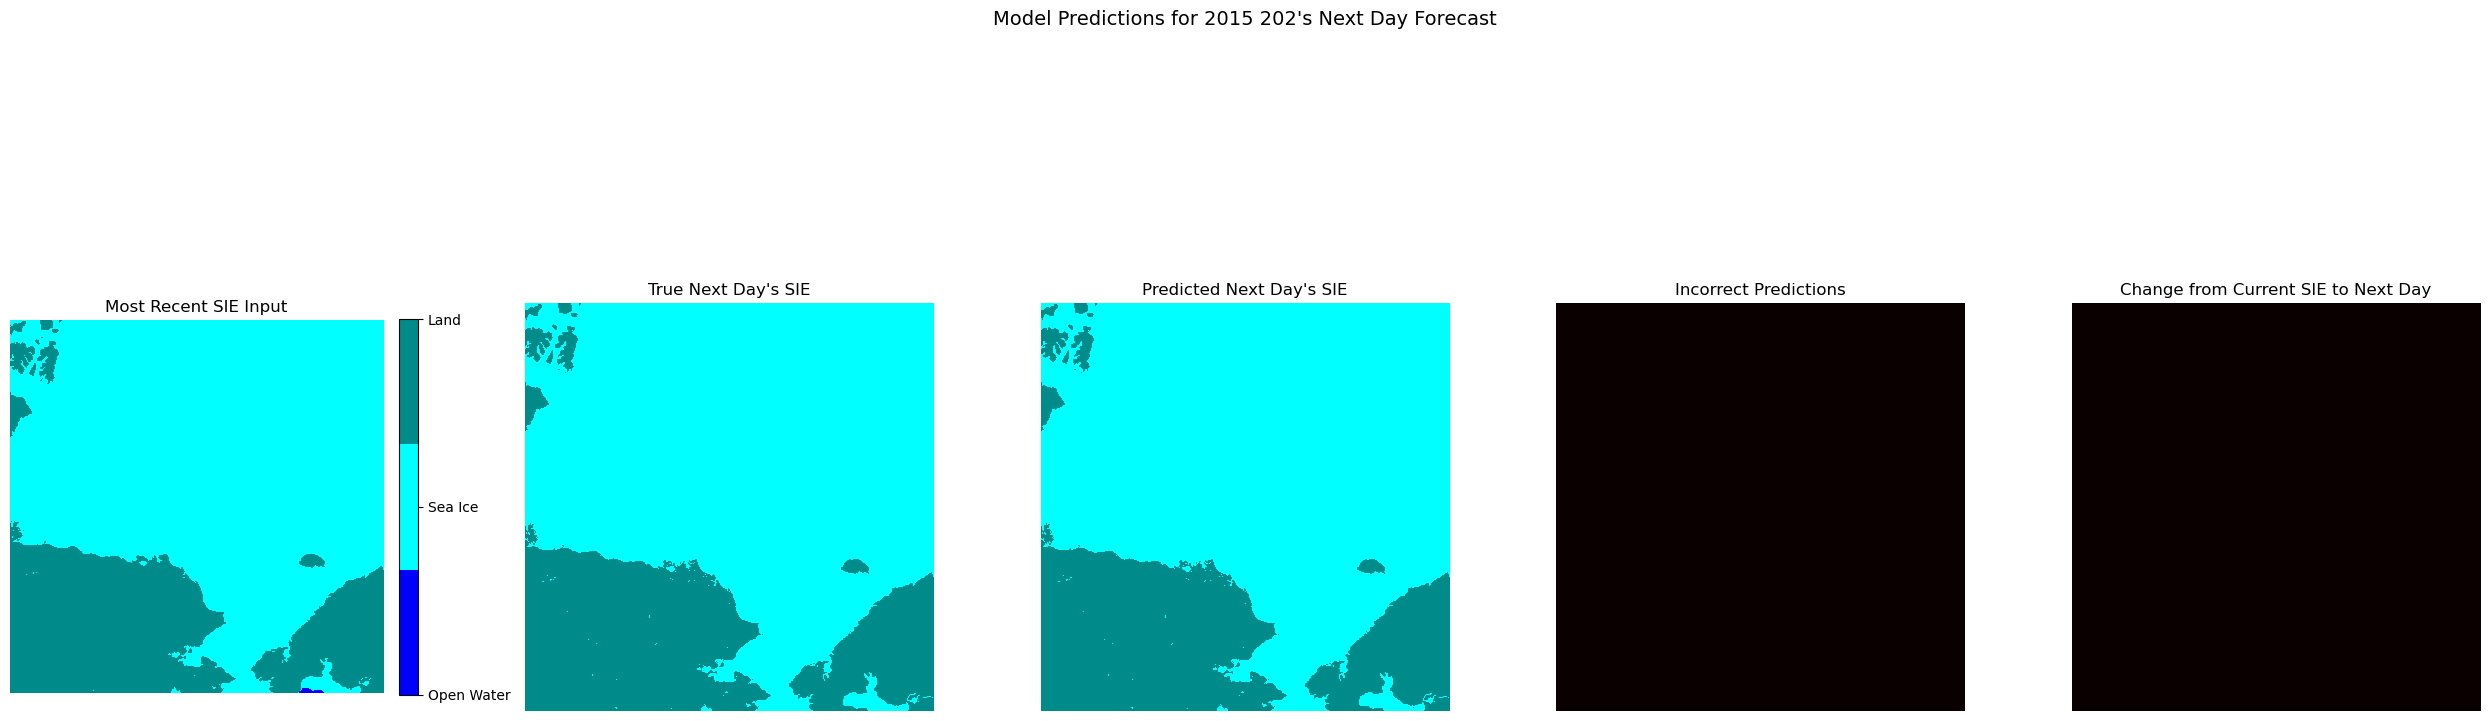

In [23]:
from matplotlib.colors import ListedColormap


def plot_model_predictions_with_errors(
    X: np.array, y_true: np.array, y_pred: np.array, year: int, day: int
):
    """
    Parameters:
     - X: np.array of shape (window_size, window_size, n_forecasts)
     - y_true: np.array of 0,1,2 (window_size, window_size, 1)
     - y_pred: model output (window_size, window_size, 1)
     - year: Integer year like 2023, for titling plot
     - day: Integer day like 18, for titling plot
    """
    print()
    print()

    X_cmap = ListedColormap(["#0000FF", "#00FFFF", "#008B8B"])
    binary_cmap = cmap = ListedColormap(["#008B8B", "#00FFFF"])

    # Calculate the incorrect predictions (difference between the predicted and true labels)
    incorrect_predictions = np.not_equal(np.round(y_pred), y_true).astype(int)
    current_SIE = X[:, :, -1].copy()
    current_SIE[current_SIE == 2] = 0
    change_from_curr_to_next = np.not_equal(current_SIE, y_true[:, :, 0]).astype(int)

    # Plotting the first example of the batch
    fig, axes = plt.subplots(1, 5, figsize=(25, 10))

    # Plot the last channel of input which is the most recent SIE
    im1 = axes[0].imshow(X[:, :, -1], cmap=X_cmap)
    axes[0].set_title("Most Recent SIE Input")
    axes[0].axis("off")

    # Plot the true label for next day's SIE
    im2 = axes[1].imshow(y_true[:, :, 0], cmap=binary_cmap)
    axes[1].set_title("True Next Day's SIE")
    axes[1].axis("off")

    # Plot the predicted next day's SIE
    im3 = axes[2].imshow(y_pred[:, :, 0], cmap=binary_cmap)
    axes[2].set_title("Predicted Next Day's SIE")
    axes[2].axis("off")

    # Plot the incorrect predictions
    im4 = axes[3].imshow(incorrect_predictions[:, :, 0], cmap="hot")
    axes[3].set_title("Incorrect Predictions")
    axes[3].axis("off")

    # Plot the SIE change
    axes[4].imshow(change_from_curr_to_next, cmap="hot")
    axes[4].set_title("Change from Current SIE to Next Day")
    axes[4].axis("off")

    # Add a color bar for the SIE plots
    cbar = fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    cbar.set_ticks([0, 1, 2])
    cbar.set_ticklabels(["Open Water", "Sea Ice", "Land"])

    fig.suptitle(f"Model Predictions for {year} {day}'s Next Day Forecast", fontsize=14)
    plt.tight_layout()
    plt.show()


# Get the batch data for test set
batch_index = 200
X_batch, y_true_batch = test_generator[batch_index]

# Generate predictions from the test data
y_pred_batch = model.predict(X_batch)
dates = test_generator.get_years_days_of_batch(batch_index)

# iterate over the batched predictions
for i in range(X_batch.shape[0]):
    plot_model_predictions_with_errors(
        X_batch[i], y_true_batch[i], y_pred_batch[i], dates[i][0], dates[i][1]
    )

# Edge Detection

## Contour-based edge detection
This is maybe ok. It's closer to what IceNet does, but they also utilize masking out all boundaries/edges that aren't sea-ice to open ocean.

It'll be very hard to line up which boundary should get compared to which. We get a collection of contiguous lines from this contour based approach, but when we get a different collection of lines/edges from the true target, how do we compare them? How do you know that you're comparing the contour around one island to that same island in the second image?

Additionally, I don't think this is differentiable, which is fine for evaluation, but it would be great to embed this into our model if possible to force it to learn how to forecast edges better.

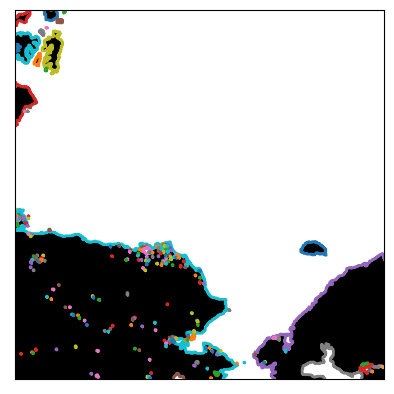

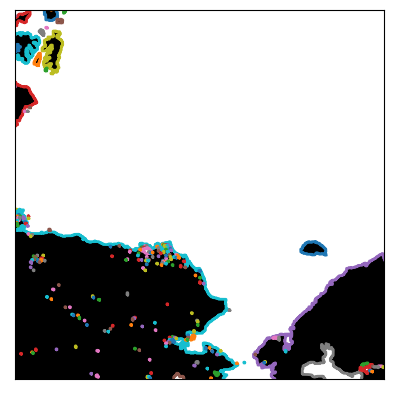

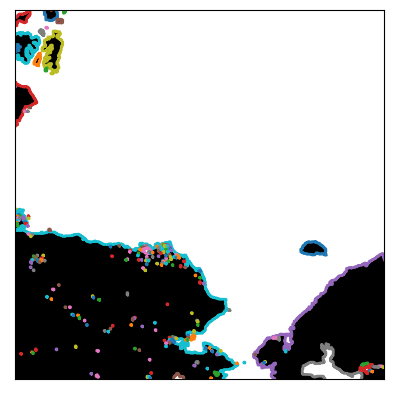

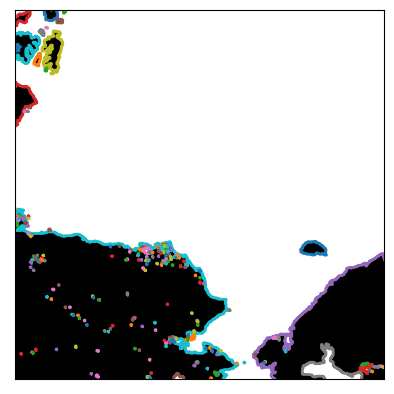

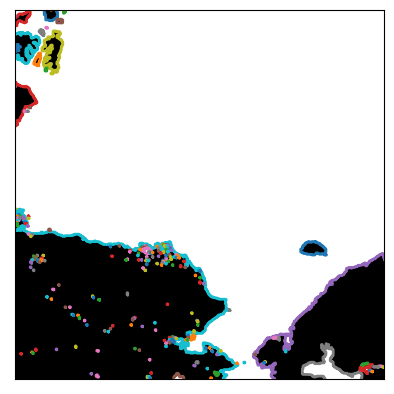

In [24]:
for i in [0.1, 0.5, 0.6, 0.7, 0.8]:
    contours = skimage.measure.find_contours(y_pred_batch[0, :, :, 0], i)

    # Display the image and plot all contours found
    fig, ax = plt.subplots()
    ax.imshow(y_pred_batch[0, :, :, 0], cmap=plt.cm.gray)

    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

    ax.axis("image")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

### Quick look at IceNet's work
```
def arr_to_ice_edge_arr(arr, thresh, land_mask, region_mask):

    '''
    Credit IceNet https://github.com/tom-andersson/icenet-paper/blob/79ab77c452088d805514d0ba2f3ad86581945954/icenet/utils.py#L1808
    Compute a boolean mask with True over ice edge contour grid cells using
    matplotlib.pyplot.contour and an input threshold to define the ice edge
    (e.g. 0.15 for the 15% SIC ice edge or 0.5 for SIP forecasts). The contour
    along the coastline is removed using the region mask.
    '''

    X, Y = np.meshgrid(np.arange(arr.shape[0]), np.arange(arr.shape[1]))
    X = X.T
    Y = Y.T

    cs = plt.contour(X, Y, arr, [thresh], alpha=0)  # Do not plot on any axes
    x = []
    y = []
    for p in cs.collections[0].get_paths():
        x_i, y_i = p.vertices.T
        x.extend(np.round(x_i))
        y.extend(np.round(y_i))
    x = np.array(x, int)
    y = np.array(y, int)
    ice_edge_arr = np.zeros(arr.shape, dtype=bool)
    ice_edge_arr[x, y] = True
    # Mask out ice edge contour that hugs the coastline
    ice_edge_arr[land_mask] = False
    ice_edge_arr[region_mask == 13] = False

    return ice_edge_arr

```

## Filter based Edge Detection: Sobel prototype
This still really needs a lake and land mask, but calculating the absolute value of the tensorflow sobel edge detection, thresholding, and combining the x, y sobel filter directions yields a very nice looking edge.

Because we don't have a land & lake mask, this is mostly picking up the edges of the landmasses. We likely want to just evaluate the sea-ice to open ocean boundary and evaluate our ice-edge metrics against that.

Really nice that this is a differentiable system, so we can embed this into our model with a little work and compute the model outputs the current SIE predictions plus the result of the sobel edge detection.

By finding a good threshold for this, we can likely just use the same loss function (binary cross entropy). This would mean computing the sobel edge detection for the y_target as well. It's still not utilizing any of the ice-edge metrics that we really care about in the loss function, but is a step towards informing the model how important ice edges are and penalizing it for incorrect edge forecasts.

In [70]:
truth = tf.convert_to_tensor(X_batch.T)
sobel = tf.image.sobel_edges(truth)
sobel_y = np.asarray(sobel[:, :, :, 0, 0])  # sobel in y-direction
sobel_x = np.asarray(sobel[:, :, :, 0, 1])  # sobel in x-direction
ideal_sobel = (np.abs(sobel_y[0]) > 1) + (np.abs(sobel_x[0]) > 1)

In [71]:
truth.shape

TensorShape([3, 2000, 2000, 1])

In [72]:
# Perform Sobel edge detection
sobel_edges = tf.image.sobel_edges(truth)
activated = Activation("sigmoid")(
    tf.square(sobel_edges[:, :, :, :, 0]) + tf.square(sobel_edges[:, :, :, :, 1])
)

In [73]:
sobel_edges.shape

TensorShape([3, 2000, 2000, 1, 2])

In [74]:
activated.shape

TensorShape([3, 2000, 2000, 1])

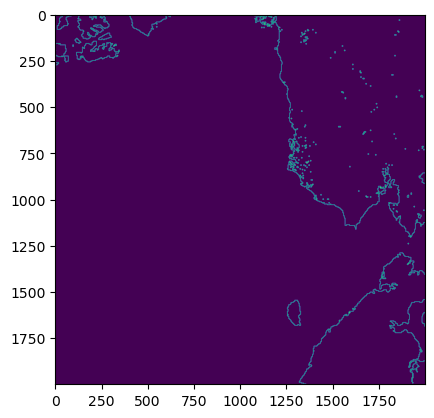

In [75]:
plt.imshow((activated[0, :, :, 0]))

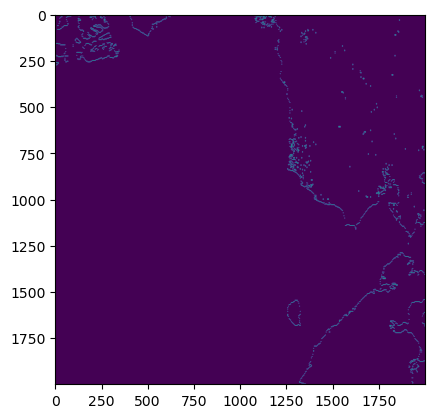

In [76]:
plt.imshow(np.abs(sobel_y[0]))

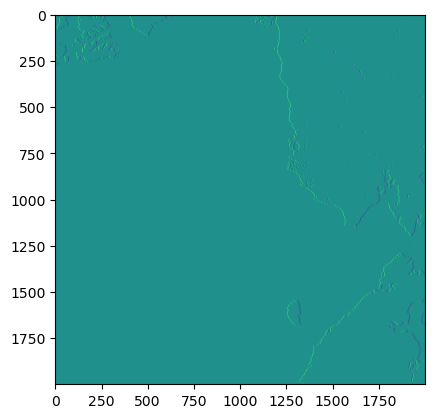

In [77]:
plt.imshow(sobel_x[0])

In [78]:
np.unique(sobel_x)

array([-8., -6., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.],
      dtype=float16)

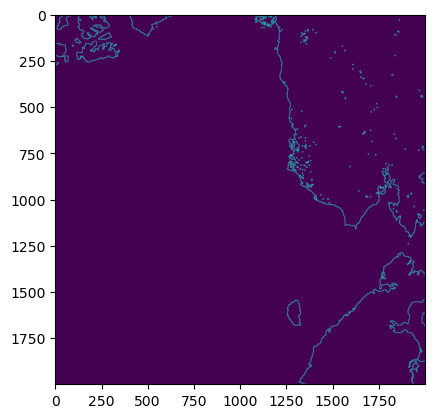

In [79]:
plt.imshow((np.abs(sobel_y[0]) > 1) + (np.abs(sobel_x[0]) > 1))

In [84]:
from numba import jit


@jit(nopython=True)
def average_ice_edge_displacement(observed_edges, model_edges):
    """
    Calculate the average ice edge displacement (D_AVG_IE) between observed and model ice edges.
    Credit: Validation metrics for ice edge position forecasts, Melsom et al., 2019.

    Parameters:
    - observed_edges: numpy array of shape (N, 2), where N is the number of observed ice edge points,
      and each point is represented by its (x, y) coordinates.
    - model_edges: numpy array of shape (M, 2), where M is the number of model ice edge points,
      and each point is represented by its (x, y) coordinates.

    Returns:
    - D_AVG_IE: The average displacement between the observed and model ice edges.
    """

    # Initialize lists to store minimum distances for each point
    observed_to_model_distances = []
    model_to_observed_distances = []

    # Calculate distances from each observed point to the nearest model point
    for obs_point in observed_edges:
        distances = np.sqrt(np.sum((model_edges - obs_point) ** 2, axis=1))
        observed_to_model_distances.append(np.min(distances))

    # Calculate distances from each model point to the nearest observed point
    for model_point in model_edges:
        distances = np.sqrt(np.sum((observed_edges - model_point) ** 2, axis=1))
        model_to_observed_distances.append(np.min(distances))

    # Calculate the average displacement
    avg_displacement = (
        sum(observed_to_model_distances) / len(observed_to_model_distances)
        + sum(model_to_observed_distances) / len(model_to_observed_distances)
    ) / 2

    return avg_displacement

In [91]:
@jit(nopython=True)
def root_mean_square_ice_edge_displacement(observed_edges, model_edges):
    """
    Calculate the root mean square ice edge displacement (D_RMS_IE) between observed and model ice edges.

    Parameters:
    - observed_edges: numpy array of shape (N, 2), where N is the number of observed ice edge points,
      and each point is represented by its (x, y) coordinates.
    - model_edges: numpy array of shape (M, 2), where M is the number of model ice edge points,
      and each point is represented by its (x, y) coordinates.

    Returns:
    - D_RMS_IE: The root mean square displacement between the observed and model ice edges.
    """

    # Initialize lists to store distances for each point
    observed_to_model_distances = []
    model_to_observed_distances = []

    # Calculate distances from each observed point to the nearest model predicted point
    for obs_point in observed_edges:
        distances = np.sqrt(np.sum((model_edges - obs_point) ** 2, axis=1))
        observed_to_model_distances.append(np.min(distances) ** 2)

    # Calculate distances from each model point to the nearest observed point
    for model_point in model_edges:
        distances = np.sqrt(np.sum((observed_edges - model_point) ** 2, axis=1))
        model_to_observed_distances.append(np.min(distances) ** 2)

    # Calculate the root mean square displacement
    rms_displacement = np.sqrt(
        (sum(observed_to_model_distances) + sum(model_to_observed_distances))
        / (len(observed_to_model_distances) + len(model_to_observed_distances))
    )

    return rms_displacement

In [92]:
edges = {}
for i in range(activated.shape[0]):
    edges[i] = np.where(activated[i, :, :, 0] >= 1)

In [94]:
for i in range(1, activated.shape[0]):
    x, y = edges[i][0], edges[i][1]
    current_edges = np.stack((x, y), axis=-1)

    x_prev, y_prev = edges[i - 1][0], edges[i - 1][1]
    previous_edges = np.stack((x_prev, y_prev), axis=-1)

    avg_displacement = average_ice_edge_displacement(current_edges, previous_edges)
    rms_displacement = root_mean_square_ice_edge_displacement(
        current_edges, previous_edges
    )
    print(avg_displacement, rms_displacement)

0.03760836743969396 0.8457719932868671
0.0 0.0


In [96]:
current_edges.shape

(26434, 2)

## Prototyping the sobel edge detection layer
Very early prototype, no promises that there aren't bugs.

In [51]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    concatenate,
    Conv2DTranspose,
    Input,
    Layer,
    Activation,
)
from tensorflow.keras.models import Model


class SobelEdgeLayer(Layer):
    def __init__(self, threshold=1, **kwargs):
        super(SobelEdgeLayer, self).__init__(**kwargs)
        self.threshold = threshold

    def call(self, inputs):
        # Perform Sobel edge detection
        sobel_edges = tf.image.sobel_edges(inputs)

        # Extract edges for x and y directions and apply sigmoid activation
        activated = Activation("sigmoid")(
            tf.square(sobel_edges[:, :, :, :, 0])
            + tf.square(sobel_edges[:, :, :, :, 1])
        )
        return activated

    def compute_output_shape(self, input_shape):
        return input_shape


def simple_unet_with_sobel(input_shape=(8000 * 2, 8000 * 2, 5)):
    inputs = Input(input_shape)
    # Downsample
    c1 = Conv2D(16, (3, 3), activation="relu", padding="same")(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation="relu", padding="same")(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    # Bottleneck
    b = Conv2D(64, (3, 3), activation="relu", padding="same")(p2)
    # Upsample
    u1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(b)
    u1 = concatenate([u1, c2])
    u2 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(u1)
    u2 = concatenate([u2, c1])

    # Class prediction layer
    class_pred = Conv2D(1, (1, 1), activation="sigmoid")(u2)

    # Sobel edge layer (applied on class prediction)
    sobel_edges = SobelEdgeLayer()(class_pred)

    # Concatenate class prediction and Sobel edge detection results
    # outputs = concatenate([class_pred, sobel_edges], axis=-1)

    model = Model(inputs=[inputs], outputs=[sobel_edges])
    return model

In [58]:
def apply_sobel_edge_detection(image, threshold=1):
    """perform Sobel edge detection on an (optionally batched) image"""
    # Ensure image is a float32 tensor for TensorFlow operations
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    print(image.get_shape())
    # Perform Sobel edge detection
    sobel = tf.image.sobel_edges(image)
    sobel_x = sobel[..., 0]
    sobel_y = sobel[..., 1]

    # Apply absolute value, threshold, and sum the results of x and y edges
    edges_x = tf.cast(tf.square(sobel_x) > threshold, tf.float32)
    edges_y = tf.cast(tf.square(sobel_y) > threshold, tf.float32)
    edges = (
        edges_x + edges_y
    )  # tf.reduce_sum(tf.concat([edges_x, edges_y], axis=-1), axis=-1, keepdims=True)

    return edges


class SobelGenerator(AllDataGenerator):
    """
    Generator for Keras training to allow multiprocessing and training on batches with only the
    batch itself being loaded into memory.
    """

    # Existing __init__, years_from_filenames, days_from_filenames, _get_data_ids, __len__, and on_epoch_end methods

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Collect data IDs for this batch number
        batch_data_ids = self.data_IDs[
            index * self.batch_size : (index + 1) * self.batch_size
        ]

        # Generate data
        X, y = self._data_generation(batch_data_ids)

        return X.astype("float16"), y.astype("float32")

    def _data_generation(self, batch_data_ids):
        """Generates data containing batch_size samples"""
        X = np.empty((self.batch_size, *self.dim), dtype="float16")
        y = np.empty((self.batch_size, self.dim[0], self.dim[1], 1), dtype="float32")

        for i, (year, day) in enumerate(batch_data_ids):
            # Load a 5-day chunk as the input
            X[i,] = self.load_n_day_chunk(i, self.dim[2])
            # Load the next day as the target
            target_image = load_target_sie_data(
                self.years[i + self.dim[2]], self.days[i + self.dim[2]]
            )
            print(target_image.shape)
            # y[i, :, :, :1] = np.expand_dims(target_image, axis=-1)
            # Apply Sobel edge detection to the target and concatenate it to y
            sobel_edges = apply_sobel_edge_detection(target_image)
            y[
                i
            ] = sobel_edges.numpy()  # Make sure to convert the TF tensor to NumPy array

        return X, y

In [59]:
def combined_loss(y_true, y_pred, beta=0.5):
    # Assume y_true and y_pred are both of shape (batch_size, height, width, channels)
    # and that the last two channels of y_pred are the Sobel edge detection results.
    # Also assume that y_true is binary (0 or 1) for the class predictions.
    class_true = y_true[..., :1]  # Extract the class prediction part from y_true
    class_pred = y_pred[..., :1]  # Extract the class prediction part from y_pred

    edge_pred = y_pred[..., 1:]  # Extract the edge detection part from y_pred

    # Binary cross-entropy for the class predictions
    bce_loss = tf.keras.losses.binary_crossentropy(class_true, class_pred)

    # MSE for the edge detection part (assuming no ground truth for edges, using predicted edges as target)
    mse_loss = tf.keras.losses.mean_squared_error(class_true, edge_pred)

    # Combine the losses
    combined = (1 - beta) * bce_loss + beta * mse_loss
    return combined

In [60]:
datetime_string = datetime.datetime.now().strftime("%I:%M%p_%B_%d_%Y")

# Model checkpoint foldernames now generated by datetime (won't overwrite previous runs)
checkpoint_dir = f"./model_checkpoints/jbacon/unet_{datetime_string}_{WINDOW_SIZE}km/"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:04d}.ckpt")

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=1,
)

early_stopping_callback = EarlyStopping(
    monitor="loss", patience=10, verbose=1, mode="min"
)

model = simple_unet_with_sobel(input_shape=dim)  # skip(input_shape=dim)

# Example of compiling the model with the custom loss
# model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy'])
sobel_train_generator = SobelGenerator(train_files, batch_size=batch_size, dim=dim)
sobel_test_generator = SobelGenerator(test_files, batch_size=test_batch_size, dim=dim)
model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)  #'binary_crossentropy', metrics=['accuracy']) 'sparse_categorical_crossentropy'

# Train the model
history = model.fit(
    sobel_train_generator,
    epochs=1,
    validation_data=sobel_test_generator,
    # Only for training on CPU
    # use_multiprocessing=True,
    # workers=2,
    callbacks=[checkpoint_callback, early_stopping_callback],
)

(2000, 2000)
(1, 2000, 2000)


InvalidArgumentError: The first dimension of paddings must be the rank of inputs[4,2], [1,2000,2000] [Op:MirrorPad]

In [ ]:
0.7243


loss started at like 0.6931